In [3]:
import pandas as pd
import yfinance as yf
import holidays
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
import mplcursors

from realPrice.OptionPnl import main, calls_or_puts
from realPrice.realOption import get_realtime_option_price


# Dummy DataFrame to hold trade data
trades_df = pd.DataFrame(columns=[
    'trade_date', 'symbol', 'strike', 'expiration', 'stock_trade_price', 'effective_delta',
    'call_trade_price', 'call_action_type', 'num_call_contracts', 'put_trade_price',
    'put_action_type', 'num_put_contracts', 'stock_close_price', 'call_close_price',
    'put_close_price', 'daily_pnl', 'change'
])

def calculate_pnl(call_action, put_action, NC, C_0, C_t, NP, P_0, P_t, effectice_delta, trade_price, current_price):
    if call_action == "sell" and put_action == "sell":
        return (NC * (C_0 - C_t) + NP * (P_0 - P_t) + effectice_delta * (current_price - trade_price)) * 100
    elif call_action == "sell" and put_action == "buy":
        return (NC * (C_0 - C_t) + NP * (P_t - P_0) + effectice_delta * (current_price - trade_price)) * 100
    elif call_action == "buy" and put_action == "sell":
        return (NC * (C_t - C_0) + NP * (P_0 - P_t) + effectice_delta * (current_price - trade_price)) * 100
    elif call_action == "buy" and put_action == "buy":
        return (NC * (C_t - C_0) + NP * (P_t - P_0) + effectice_delta * (current_price - trade_price)) * 100
    else:
        return 0  

def market_open():
    today = datetime.now()  
    eastern = pytz.timezone('US/Eastern')
    current_time_et = datetime.now(eastern).time()
    market_open = datetime.strptime("09:30", "%H:%M").time()
    market_close = datetime.strptime("16:00", "%H:%M").time()
    return market_open <= current_time_et <= market_close and today.weekday() < 5 and today not in holidays.US()

def fetch_and_add_trade(trades_df, trade_date, symbol, strike, expiration, stock_trade_price, call_trade_price, put_trade_price, effective_delta, num_call_contracts, num_put_contracts, call_action_type, put_action_type):
    # Fetch historical data
    option_data = main(symbol, expiration, strike, trade_date)
    
    if option_data is None or option_data.empty:
        print("No data found or unable to retrieve data.")
        return trades_df

    # Fetch real-time data if market is open
    if market_open():
        options = calls_or_puts(symbol, expiration, strike)
        if options and len(options) == 2:
            call_close_price, call_ask_price, call_bid_price = get_realtime_option_price(options[0])
            put_close_price, put_ask_price, put_bid_price = get_realtime_option_price(options[1])
            option_data.at[option_data.index[-1], 'call_close_price'] = call_ask_price if call_action_type == "sell" else call_bid_price
            option_data.at[option_data.index[-1], 'put_close_price'] = put_ask_price if put_action_type == "sell" else put_bid_price

    # Proceed with updating trades and calculating PNL
    if option_data is not None and not option_data.empty:
        for _, row in option_data.iterrows():
            daily_pnl = calculate_pnl(call_action_type, put_action_type,
                                    num_call_contracts, call_trade_price, row['call_close_price'],
                                    num_put_contracts, put_trade_price, row['put_close_price'],
                                    effective_delta, stock_trade_price, row['stock_close_price'])
            daily_pnl = round(daily_pnl, 2)
            investment = ((num_call_contracts * call_trade_price) + (num_put_contracts * put_trade_price)) * 100
            change = round(daily_pnl / investment * 100, 2)
            new_trade = {
                'trade_date': row['date'].strftime('%Y-%m-%d'),
                'symbol': symbol,
                'strike': strike,
                'expiration': expiration,
                'stock_trade_price': stock_trade_price,
                'effective_delta': effective_delta,
                'call_trade_price': row['call_close_price'],
                'call_action_type': call_action_type,
                'num_call_contracts': num_call_contracts,
                'put_trade_price': row['put_close_price'],
                'put_action_type': put_action_type,
                'num_put_contracts': num_put_contracts,
                'stock_close_price': round(row['stock_close_price'], 2),
                'call_close_price': row['call_close_price'],
                'put_close_price': row['put_close_price'],
                'daily_pnl': daily_pnl,
                'change': change
            }

            # Check if the trade already exists in the DataFrame
            exists = trades_df[
                (trades_df['trade_date'] == new_trade['trade_date']) &
                (trades_df['symbol'] == new_trade['symbol']) &
                (trades_df['strike'] == new_trade['strike']) &
                (trades_df['expiration'] == new_trade['expiration']) &
                (trades_df['stock_trade_price'] == new_trade['stock_trade_price']) &
                (trades_df['effective_delta'] == new_trade['effective_delta']) &
                (trades_df['call_trade_price'] == new_trade['call_trade_price']) &
                (trades_df['call_action_type'] == new_trade['call_action_type']) &
                (trades_df['num_call_contracts'] == new_trade['num_call_contracts']) &
                (trades_df['put_trade_price'] == new_trade['put_trade_price']) &
                (trades_df['put_action_type'] == new_trade['put_action_type']) &
                (trades_df['num_put_contracts'] == new_trade['num_put_contracts']) 
            ]
            
            if not exists.empty:     
                trades_df = trades_df.drop(exists.index)
                print("Trade already exists. Skipping duplicate entry.")
                continue

            # Add the new trade to the DataFrame
            new_df = pd.DataFrame([new_trade])
            trades_df = pd.concat([trades_df, new_df], ignore_index=True)

    return trades_df

def plot_pnl(trades_df, trade_date, symbol, strike, expiration, call_action_type, put_action_type, num_call_contracts, num_put_contracts, stock_trade_price, effective_delta):
    filtered_data = trades_df[
        (trades_df['symbol'] == symbol) &
        (trades_df['strike'] == strike) &
        (trades_df['expiration'] == expiration) &
        (trades_df['trade_date'] >= trade_date) &
        (trades_df['call_action_type'] == call_action_type) &
        (trades_df['put_action_type'] == put_action_type) &
        (trades_df['num_call_contracts'] == num_call_contracts) &
        (trades_df['num_put_contracts'] == num_put_contracts) &
        (trades_df['stock_trade_price'] == stock_trade_price) &
        (trades_df['effective_delta'] == effective_delta)     
    ]
    
    if not filtered_data.empty:
        filtered_data = filtered_data.sort_values(by='trade_date')
        filtered_data['trade_date'] = pd.to_datetime(filtered_data['trade_date'])
        filtered_data['plot_index'] = range(len(filtered_data))
        date_labels = {row['plot_index']: row['trade_date'].strftime('%m-%d') for index, row in filtered_data.iterrows()}
        colors = ['#bd1414' if x < 0 else '#007560' for x in filtered_data['daily_pnl']]
        hover_texts = []
        for idx, row in filtered_data.iterrows():
            hover_text = f"Date: {row['trade_date'].strftime('%Y-%m-%d')}\n" \
                        f"Stock: ${row['stock_close_price']:.2f}\n" \
                        f"Call: ${row['call_close_price']:.2f}\n" \
                        f"Put: ${row['put_close_price']:.2f}\n" \
                        f"Daily PNL: ${row['daily_pnl']:.2f}\n" \
                        f"Change: {row['change']:.2f}%"
            hover_texts.append(hover_text)
        filtered_data['hover_text'] = hover_texts

        plt.figure(figsize=(10, 6))
        
        scatter = plt.scatter(filtered_data['plot_index'], filtered_data['daily_pnl'], c=colors, s=100)
        plt.plot(filtered_data['plot_index'], filtered_data['daily_pnl'], color='black', linewidth=2)

        subtitle = f'{call_action_type.capitalize()} {num_call_contracts} Call(s) & {put_action_type.capitalize()} {num_put_contracts} Put(s)'

        plt.title(f"Profit & Loss\n{subtitle}", fontsize=14)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Π', fontsize=14)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
        plt.grid(True)

        plt.xticks(list(date_labels.keys()), list(date_labels.values()), rotation=45, ha='right')
        
        plt.gca().tick_params(axis='x', labelsize=10)
        plt.gca().tick_params(axis='y', labelsize=10)

        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(filtered_data['hover_text'].iloc[sel.index]))
        plt.show()
    else:
        print("No data to display for selected filters.")



Call option(s) for strike price 415 on 2024-07-19: MSFT240719C00415000
Put option(s) for strike price 415 on 2024-07-19: MSFT240719P00415000
          date  call_close_price  put_close_price  stock_close_price
0   2024-05-08             13.90            15.15             409.80
1   2024-05-09             14.40            13.70             411.58
2   2024-05-10             15.30            12.31             413.99
3   2024-05-13             14.57            12.45             412.98
4   2024-05-14             16.30            10.98             415.81
5   2024-05-15             20.05             7.75             423.08
6   2024-05-16             18.80             8.46             420.99
7   2024-05-17             17.60             8.65             420.21
8   2024-05-20             20.45             6.81             425.34
9   2024-05-21             23.22             5.40             429.04
10  2024-05-22             22.42             5.80             430.52
11  2024-05-23             21.6

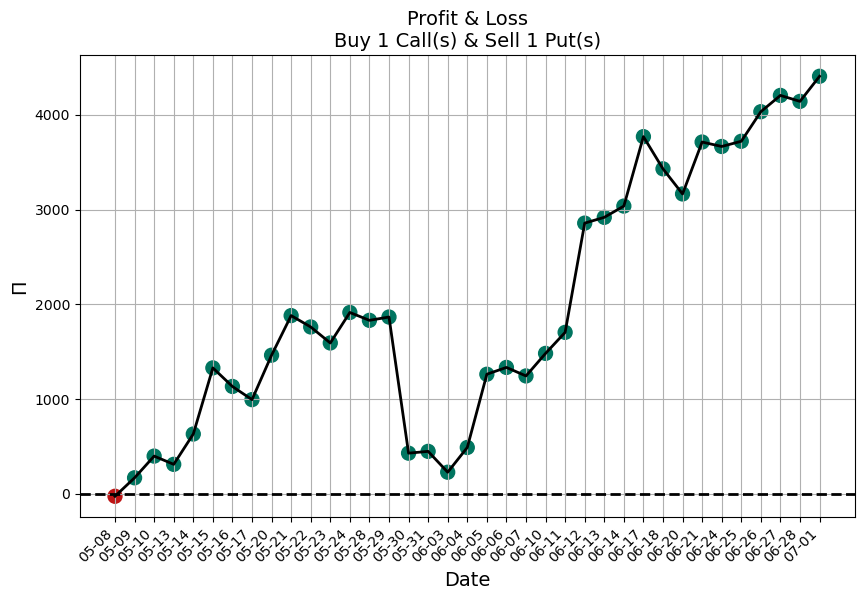

In [6]:
trade_date = '2024-05-08'
symbol = 'MSFT'
strike = 415
expiration = '2024-07-19'
stock_trade_price = 412.00
call_trade_price = 11
put_trade_price = 12
effective_delta = 0
num_call_contracts = 1
num_put_contracts = 1
call_action_type = "buy"
put_action_type = "sell"

# Fetch and add trade to the DataFrame
trades_df = fetch_and_add_trade(trades_df, trade_date, symbol, strike, expiration, stock_trade_price, call_trade_price, put_trade_price, effective_delta, num_call_contracts, num_put_contracts, call_action_type, put_action_type)
print(trades_df)
# Plot the PNL
plot_pnl(trades_df, trade_date, symbol, strike, expiration, call_action_type, put_action_type, num_call_contracts, num_put_contracts, stock_trade_price, effective_delta)
